In [1]:
import numpy as np
from matplotlib import pyplot as plt
from scipy import interpolate as interp

# Problem 1

### a)

We look at the taylor expansion of $f(x \pm dx)$ and $f(x \pm 2dx)$

$$f(x \pm dx) = f(x) \pm f'(x)dx + \frac{f''(x)dx^2}{2} \pm \frac{f^{(3)}(x)dx^3}{6} + ...$$

$$f(x \pm 2dx) = f(x) \pm 2f'(x)dx + \frac{4f''(x)dx^2}{2} \pm \frac{8f^{(3)}(x)dx^3}{6} + ...$$

Now we take some linear combination of these expressions to arrive at an expression for $f'(x)$ and an estimate of the error.

$$A(f(x+dx) - f(x-dx)) + B(f(x+2dx) - f(x-2dx))$$

Take $A = 8, B = -1$:

$$8f(x+dx) - 8f(x-dx) - f(x+2dx) + f(x-2dx) = 12f'(x)dx + ...$$

We see all the even powers of $dx$ cancel, so the error term will have leading order of $dx^5$. The next term in the taylor expantion is:

$$8\left(\frac{2f^{(5)}(x)dx^5}{5!}\right) - \left(\frac{2\times32f^{(5)}(x)dx^5}{5!}\right) = \frac{-48f^{(5)}(x)dx^5}{5!}$$

Then our estimate for the first derivative of f at x is (including leading order error):

$$f'(x) = \frac{8f(x+dx) - 8f(x-dx) - f(x+2dx) + f(x-2dx)}{12dx} + \frac{f^{(5)}(x)dx^4}{30}$$

### b)

On top of the approximation error from neglecting higher orders of the taylor expansion, our estimates will also have rounding errors due to machine precision. If calculating each of $f(x \pm dx)$ and $f(x \pm 2dx)$ produce a rounding error of about $\epsilon |f(x)|$, where $\epsilon \approx 10^{-16}$ is the accuracy of the machine for double precision, then we have a rounding error of $\approx \frac{4 \epsilon |f(x)|}{dx}$.

The total error is now given by:

$$\epsilon_T = \frac{f^{(5)}(x)dx^4}{30} + \frac{4 \epsilon |f(x)|}{dx}$$

We minimize this with respect to dx to find the optimal dx for each derivative operation and find that

$$dx = \left(30\epsilon\left|\frac{f(x)}{f^{(5)}(x)}\right|\right)$$

Is the optical $dx$ to use when finding the derivative in this way. 

Now we show that this estimate for $dx$ indeed corresponds to the lowest error in our derivative estimates for $f(x) = e^{x}$ and $f(x) = e^{0.01x}$

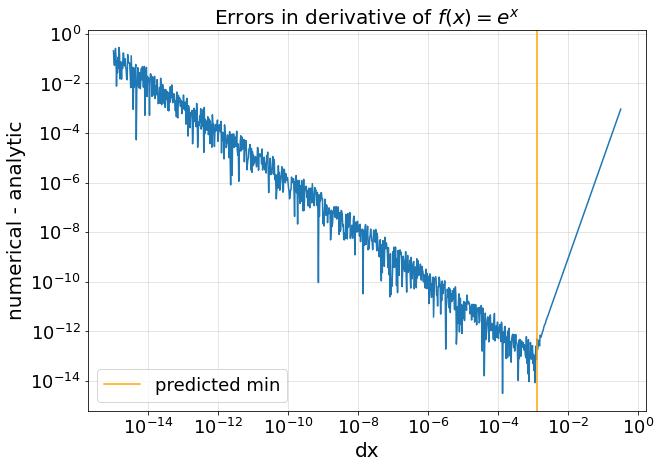

In [2]:
dx=np.logspace(-15,-0.5,1001)  # range of dx values to use
fun=np.exp  # function to differentiate
x0=1  # value at which to differentiate

y0=fun(x0+dx)
y1=fun(x0-dx)
y2=fun(x0+2*dx)
y3=fun(x0-2*dx)

deriv = (8*y0 - 8*y1 + y3 - y2)/(12*dx)  # estimating derivative
true = np.exp(x0)  # true value of derivative
pred_dx = (30 * 1e-16 * np.e / np.e)**(1/5)  # predicted optical dx

# plotting the errors vs choice of dx
plt.figure(figsize=(10,7))
plt.loglog(dx,np.abs(deriv - true))
plt.axvline(pred_dx, color='orange', label='predicted min')
plt.xlabel('dx', fontsize=20)
plt.ylabel('numerical - analytic', fontsize=20)
plt.title(r'Errors in derivative of $f(x) = e^x$', fontsize=20)
plt.legend(fontsize=18)
plt.grid(alpha=0.4)
plt.xticks(size=18)
plt.yticks(size=18)
plt.show()

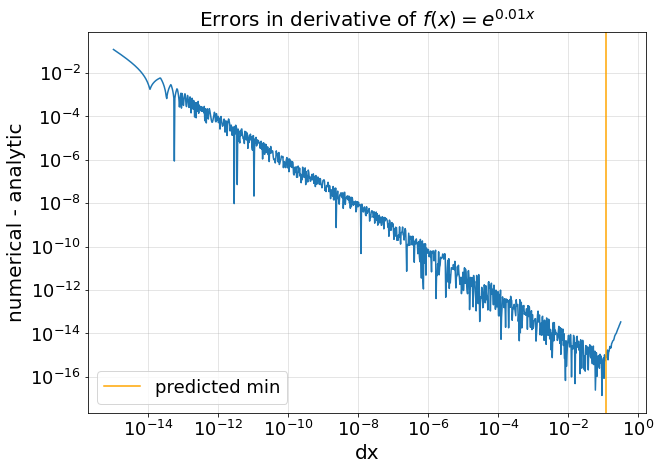

In [3]:
dx=np.logspace(-15,-0.5,1001)  # range of dx values to use
fun=np.exp  # function to differentiate
x0=1  # value at which to differentiate

y0=np.exp(0.01*(x0+dx))
y1=np.exp(0.01*(x0-dx))
y2=np.exp(0.01*(x0+2*dx))
y3=np.exp(0.01*(x0-2*dx))

deriv = (8*y0 - 8*y1 + y3 - y2)/(12*dx)  # estimating derivative
true = (0.01)*np.exp(0.01*x0)  # true value of derivative
# predicted optical dx
pred_dx = (30*1e-16*np.e**0.01 / 0.01**5/np.e**0.1)**(1/5)  

#make a log plot of our errors in the derivatives
plt.figure(figsize=(10,7))
plt.loglog(dx,np.abs(deriv - true))
plt.axvline(pred_dx, color='orange', label='predicted min')
plt.xlabel('dx', fontsize=20)
plt.ylabel('numerical - analytic', fontsize=20)
plt.title(r'Errors in derivative of $f(x) = e^{0.01x}$', fontsize=20)
plt.grid(alpha=0.4)
plt.xticks(size=18)
plt.yticks(size=18)
plt.legend(fontsize=18)
plt.show()

We see that the predictions roughly match with the minimum error in the derivative estimations.

# Problem 2

In my function, I estimate the optimal value of dx by calculating the derivative for each dx in a range of dxs. I then take the average value produced by those dxs and take that as my "true value" for the derivative. Then, from the derivatives I had calculated earlier, I take the dx that makes the closest estimate to that average and use that to return the final estimate for the derivative of the function at x. To estimate the error, I look at the standard deviation of the predicted derivatives weighted by the number of dxs tried. So far, my function only works for single values of x as input. 

I show an example for fun = cos(x), x = 1. I see that the error estimated does, in fact, agree with the difference between this result and the true value of the derivative at that point

In [152]:
def ndiff(fun,x,full=False):
    '''Estimated the first derivative of a function at x
    Inputs:
    - fun: function to be derived
    - x <float>: value at which to find the derivate of fun
    - full <bool>: if True, returns include estimated optimal dx and error values
    Returns:
    - final_deriv <float>: estimated value of the derivative of fun at x
    - dx <float>: roughly estimated optimal dx for the calculation
    - err <float>: roughly estimated error in the calculation
    '''
    dxs=np.logspace(-15,-2,1001)  # range of dx values to use
    derivs = []

    # estimating a value for the derivative for each dx
    for dx in dxs:
        y1=fun(x+dx)
        y2=fun(x-dx)
        d = (y1 - y2)/(2*dx)
        derivs.append(d)

    # finding the average of all derivatives and the error on the estimate
    av_deriv = np.mean(derivs)
    err = np.std(derivs) / np.sqrt(len(dxs))

    # getting the dx with smallest difference to the average
    diff = abs(derivs - av_deriv)
    ind = np.where(diff == diff.min())[0][0]

    # final estimate for the derivative
    dx = dxs[ind]
    y1=fun(x+dx)
    y2=fun(x-dx)
    final_deriv = (y1 - y2)/(2*dx)
    
    if full:
        return final_deriv, dx, err
    else:
        return final_deriv

In [167]:
x = 1
final_deriv, dx, err = ndiff(np.cos, x, full=True)

In [168]:
print(final_deriv, dx, err)

-0.8414245902459376 7.030723198838327e-13 0.00016547441346515728


# Problem 3

For the interpolation, I used the cubic spline class from the scipy interpolate library. In order to estimate the errors on the interpolated values, I used bootstrap resampling. I took a total of 1000 resamples for each value of T interpolated. Then at each iteration, I used 80% of the given data points to produce the cubic spline. At the end, I took the mean and std of the interpolated values for each of the inputted voltages and used those for my estimate and estimated uncertainties. 

My function works for both single inputs of voltages and array inputs. The figure below shows the result of the interpolated temperatures of 21 voltages.

In [16]:
def lakeshore(V, data):
    '''Interpolates voltages into temperatures with some uncertainty
    Inputs:
    - V <int> or <ndarray>: Value(s) of V at which to interpolate
    - data <ndarray>: data given to compute interpolation
    Returns:
    - temps <int> or <ndarray>: interpolated temperature(s)
    - err <int> or <ndarray>: errors on the estimate(s)
    '''
    # splitting data into components
    T_given = data[::,0][::-1]
    V_given = data[::,1][::-1]
    
    '''bootstrapping to estimate the error'''
    Nresamples = 1000  # num of times to resample from given data
    Ts = []
    
    for n in range(Nresamples):
        rng = np.random.default_rng()
        inds = np.arange(len(V_given))
        # picking a subset of 80% of points from given data to perform the interpolation
        subsample = rng.choice(inds, int(len(inds)*0.8), replace=False)
        subsample.sort()
    
        # generate the spline using scipy
        cs = interp.CubicSpline(V_given[subsample], T_given[subsample])
        temp = cs(V)
    
        Ts.append(temp)
    
    # getting mean values of T and estimating error given the bootstrap method
    temps = np.mean(Ts, axis=0)
    err = np.std(Ts, axis=0) / np.sqrt(Nresamples) 

    return temps, err

In [17]:
data = np.loadtxt("./lakeshore.txt")
T_given = data[::,0][::-1]
V_given = data[::,1][::-1]

V = np.linspace(0.1, 1.5, 21)
#V = 1.1
temps, err = lakeshore(V, data)

In [19]:
print(temps)

[495.65295501 465.37495844 436.10939075 406.69243132 377.02441378
 347.16740984 317.14010894 286.80384663 255.99061588 224.59445217
 192.44420737 159.28508602 124.61401586  87.34845191  45.68046572
  22.53406159  18.54613068  14.23806065  10.92618543   8.42048594
   6.41811071]


In [20]:
print(err)

[2.51698207e-03 3.20453615e-04 6.11777238e-05 2.68731674e-05
 1.94304000e-05 1.04981730e-04 2.85138423e-04 2.38767901e-03
 1.75940555e-03 1.67684554e-04 1.43304117e-05 2.41346967e-05
 3.37051454e-05 5.92488993e-06 1.89622791e-05 5.86197482e-03
 1.82719107e-05 5.96063079e-06 3.80110587e-06 5.66746867e-06
 2.80518523e-06]


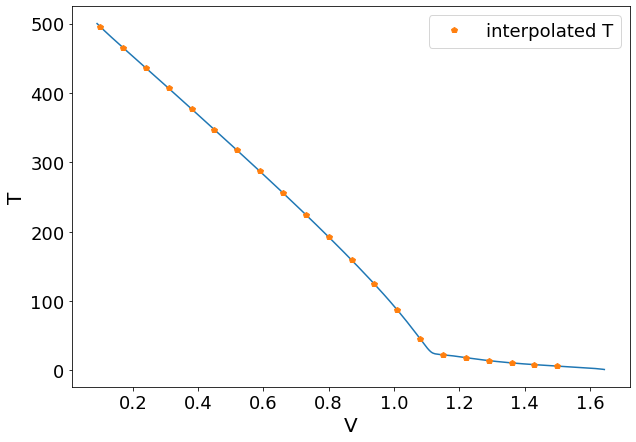

In [18]:
plt.figure(figsize=(10,7))
plt.plot(V_given, T_given)
plt.plot(V, temps, 'p', label='interpolated T')
plt.xlabel('V', fontsize=20)
plt.ylabel('T', fontsize=20)
plt.xticks(size=18)
plt.yticks(size=18)
plt.legend(fontsize=18)
plt.show()

# Problem 4

In [8]:
'''functions provided by prof sievers in class for rational interpolation, comments added by me'''

def rat_eval(p,q,x):
    '''Computes the rational function interpolation
    Inputs:
    - p, q <ndarray>: coefficients of num/denom of rational function
    - x <ndarray>: x values at which to interpolate
    Returns:
    - top/bot <ndarray>: interpolated y values
    '''
    # estimating value of the numerator at x
    top=0
    for i in range(len(p)):
        top = top + p[i]*x**i
    # estimating value of the denominator at x (constant term set to 1)
    bot = 1
    for i in range(len(q)):
        bot = bot + q[i]*x**(i+1)
    return top/bot

def rat_fit(x,y,n,m):
    '''Fits the coefficients for a rational function
    Inputs:
    - x <ndarray>: x values
    - y <ndarray>: y values known to correspond to those x values
    - n, m <ints>: order of numerator, denominator
    Returns:
    - p, q <ndarray>: coefficients of num/denom of rational function
    '''
    # setting up matrix of coefficients for interpolation
    mat = np.zeros([n+m-1, n+m-1])
    for i in range(n):
        mat[:,i]=x**i
    for i in range(1,m):
        mat[:,i-1+n]=-y*x**i
    pars=np.dot(np.linalg.inv(mat),y)
    p=pars[:n]
    q=pars[n:]
    return p,q

### y = cos(x)

In [9]:
# defining degrees of polynomials on numerator and denominator of rational function
n=4
m=5

# defining points to use for interpolation
xs = np.linspace(-np.pi/2, np.pi/2, n+m-1)
xfine = np.linspace(-np.pi/2, np.pi/2, 41)

In [10]:
# defining function to use
fun = np.cos

# defining original values and true values 
# to compare to interpolation results
ys = fun(xs)
true = fun(xfine)

In [11]:
# polynomial of degere 4
deg = 4
pp = np.polyfit(xs, ys, deg)
pred_poly = np.polyval(pp, xfine)

# cubic spline
spl=interp.CubicSpline(xs,ys) 
pred_spl = spl(xfine)

# rational
p,q = rat_fit(xs, ys, n, m)
pred_rat = rat_eval(p,q,xfine)

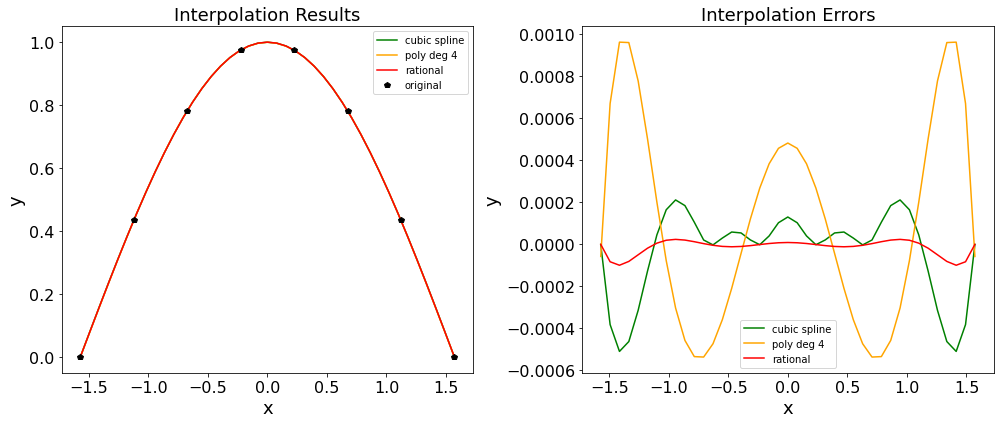

In [12]:
fig, axs = plt.subplots(1, 2, figsize=(14,6))

axs[0].plot(xfine, pred_spl, color='green', label='cubic spline')
axs[0].plot(xfine, pred_poly, color='orange', label='poly deg 4')
axs[0].plot(xfine, pred_rat, color='red', label='rational')
axs[0].plot(xs, ys, 'p', color='black', label='original')
axs[0].legend()
axs[0].set_xlabel('x', fontsize=18)
axs[0].set_ylabel('y', fontsize=18)
axs[0].set_title('Interpolation Results', fontsize=18)
axs[0].tick_params(axis='both', labelsize=16)

axs[1].plot(xfine, true-pred_spl, color='green', label='cubic spline')
axs[1].plot(xfine, true-pred_poly, color='orange', label='poly deg 4')
axs[1].plot(xfine, true-pred_rat, color='red', label='rational')
axs[1].legend()
axs[1].set_xlabel('x', fontsize=18)
axs[1].set_ylabel('y', fontsize=18)
axs[1].set_title('Interpolation Errors', fontsize=18)
axs[1].tick_params(axis='both', labelsize=16)

fig.tight_layout()
plt.show()

Looking at the Interpolation results, it doesn't seem that any of the 3 methods do a terrible job at interpolation, as there are no large scale obvious deviations. Now, looking at the errors, we find that the rational function interpolation is the most accurate overall. The polynomial interpolation gives us much larger errors over the whole range of xs and in particular performs worst on the ends. The cubic spline has smaller errors in comparison but also performs worst on the ends compared to the rational function interpolation. 

The rational function clearly performs better when interpolating points from f(x) = cos(x).

### y = 1/(1+x^2)

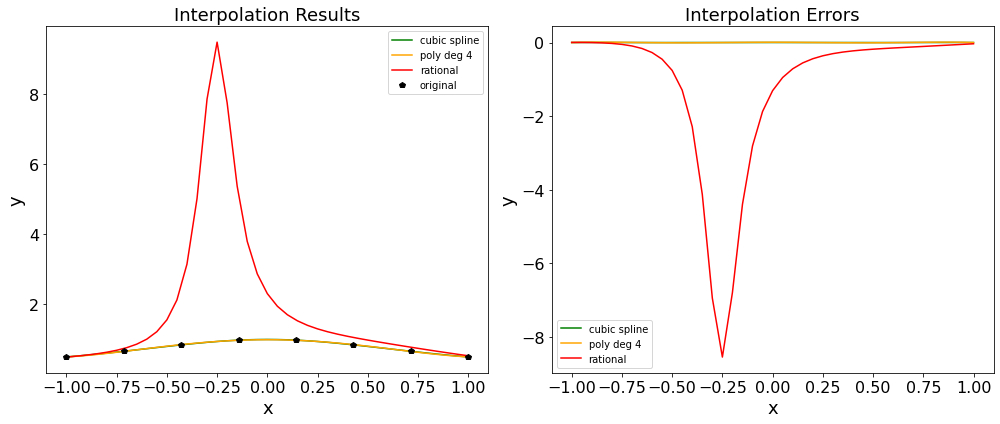

In [13]:
def lorentzian(x):
    return 1 / (1+x**2)

# defining degrees of polys on numerator and denominator of rat fun
n=4
m=5

# defining points to use for interpolation
xs = np.linspace(-1, 1, n+m-1)
xfine = np.linspace(-1, 1, 41)

# defining function to use
fun = lorentzian

# defining original values and true values 
# to compare to interpolation results
ys = fun(xs)
true = fun(xfine)

# polynomial
deg = 4
pp = np.polyfit(xs, ys, deg)
pred_poly = np.polyval(pp, xfine)

# cubic spline
spl=interp.splrep(xs,ys) 
pred_spl = interp.splev(xfine, spl)

# rational
p,q = rat_fit(xs, ys, n, m)
pred_rat = rat_eval(p,q,xfine)

fig, axs = plt.subplots(1, 2, figsize=(14,6))

axs[0].plot(xfine, pred_spl, color='green', label='cubic spline')
axs[0].plot(xfine, pred_poly, color='orange', label='poly deg 4')
axs[0].plot(xfine, pred_rat, color='red', label='rational')
axs[0].plot(xs, ys, 'p', color='black', label='original')
axs[0].legend()
axs[0].set_xlabel('x', fontsize=18)
axs[0].set_ylabel('y', fontsize=18)
axs[0].set_title('Interpolation Results', fontsize=18)
axs[0].tick_params(axis='both', labelsize=16)

axs[1].plot(xfine, true-pred_spl, color='green', label='cubic spline')
axs[1].plot(xfine, true-pred_poly, color='orange', label='poly deg 4')
axs[1].plot(xfine, true-pred_rat, color='red', label='rational')
axs[1].legend()
axs[1].set_xlabel('x', fontsize=18)
axs[1].set_ylabel('y', fontsize=18)
axs[1].set_title('Interpolation Errors', fontsize=18)
axs[1].tick_params(axis='both', labelsize=16)

fig.tight_layout()
plt.show()

I expected the error of the rational function interpolation to be very close to 0, as we are in fact fitting a rational function. However, based on both the interpolation and the errors, we see something definitely went wrong. In fact, even the prediction very near the given points were very far off for the rational function interpolation. This points to the fact that the error here is more than just to to approximation or rounding and is more closely related to the properties of the Lorentzian function and the rational interpolation. 

In terms of the coefficients, this can be understood by the fact that given 5 orders on the denominator, we essentially have the coefficients of every term but the squared one acting redundantly. Analytically , we know they should be 0 for the denominator to match what we see in the Lorentzian. Computationally, we end up with non zero small numbers that make the matrix singular. This relates to why we set the constant term to 1 in the denominator, as otherwise we have an extra coefficient to what we need to uniquely define the rational function. 

Now, switching np.linalg.inv to np.linalg.pinv, we see what we expected in the first place, which is a very small error for the rational function interpolation (on the order of $10^{-15}$). The reason this works is because the rational function very closely matches the Lorentzian function. Due to that, a lot of the coefficients end up being very small and so when taking the inverse, those tend to infinity. np.linalg.pinv takes those infinities and turns them to zeros so we still have a reasonable answer. 

Below we see how the issues are resolved by applying what has been explained here. 

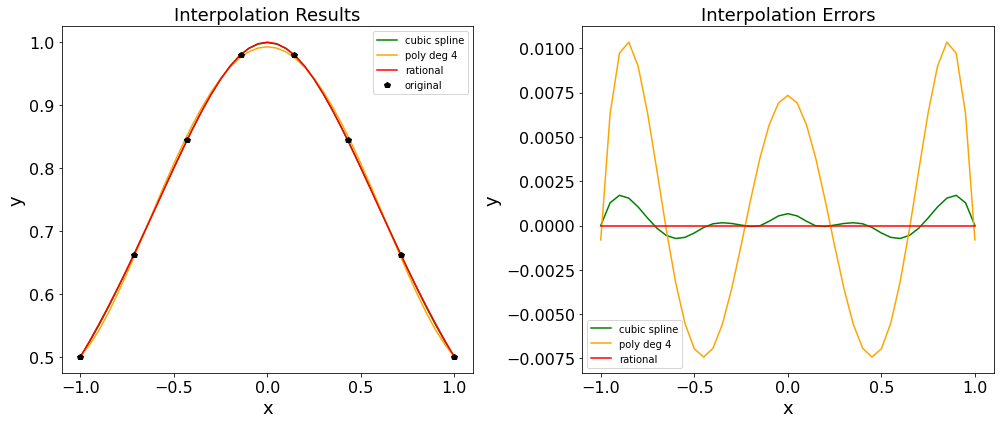

In [14]:
def rat_fit_p(x,y,n,m):
    '''same function as before, but using pinv instead'''
    mat = np.zeros([n+m-1, n+m-1])
    for i in range(n):
        mat[:,i]=x**i
    for i in range(1,m):
        mat[:,i-1+n]=-y*x**i
    pars=np.dot(np.linalg.pinv(mat),y)
    p=pars[:n]
    q=pars[n:]
    return p,q

# rational
p,q = rat_fit_p(xs, ys, n, m)
pred_rat = rat_eval(p,q,xfine)

fig, axs = plt.subplots(1, 2, figsize=(14,6))

axs[0].plot(xfine, pred_spl, color='green', label='cubic spline')
axs[0].plot(xfine, pred_poly, color='orange', label='poly deg 4')
axs[0].plot(xfine, pred_rat, color='red', label='rational')
axs[0].plot(xs, ys, 'p', color='black', label='original')
axs[0].legend()
axs[0].set_xlabel('x', fontsize=18)
axs[0].set_ylabel('y', fontsize=18)
axs[0].set_title('Interpolation Results', fontsize=18)
axs[0].tick_params(axis='both', labelsize=16)

axs[1].plot(xfine, true-pred_spl, color='green', label='cubic spline')
axs[1].plot(xfine, true-pred_poly, color='orange', label='poly deg 4')
axs[1].plot(xfine, true-pred_rat, color='red', label='rational')
axs[1].legend()
axs[1].set_xlabel('x', fontsize=18)
axs[1].set_ylabel('y', fontsize=18)
axs[1].set_title('Interpolation Errors', fontsize=18)
axs[1].tick_params(axis='both', labelsize=16)

fig.tight_layout()
plt.show()